In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tokenized-datasets/tokenized_datasets/data-00000-of-00005.arrow
/kaggle/input/tokenized-datasets/tokenized_datasets/state.json
/kaggle/input/tokenized-datasets/tokenized_datasets/dataset_info.json
/kaggle/input/tokenized-datasets/tokenized_datasets/data-00003-of-00005.arrow
/kaggle/input/tokenized-datasets/tokenized_datasets/data-00002-of-00005.arrow
/kaggle/input/tokenized-datasets/tokenized_datasets/data-00004-of-00005.arrow
/kaggle/input/tokenized-datasets/tokenized_datasets/data-00001-of-00005.arrow


In [1]:
# 1. 저장된 토크나이즈 데이터 불러오기
import shutil
shutil.copytree("/kaggle/input/tokenized-datasets/tokenized_datasets", "/kaggle/working/tmp_tokenized")
from datasets import load_from_disk
tokenized_datasets = load_from_disk("/kaggle/working/tmp_tokenized");tokenized_datasets

Dataset({
    features: ['original_text', 'summary_text', 'source_type', 'input_text', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 288174
})

In [2]:
# 2. train/val 분할

train_test_split = tokenized_datasets.train_test_split(test_size=0.2, seed=727)  # 20%를 테스트셋으로 나눔

# 데이터셋을 'train'과 'test'로 분리
train_dataset = train_test_split['train']
val_dataset = train_test_split['test']

columns_to_remove = ['original_text', 'summary_text', 'source_type', 'input_text', 'token_type_ids']

train_dataset = train_dataset.remove_columns(columns_to_remove)
val_dataset = val_dataset.remove_columns(columns_to_remove)

# 훈련 데이터셋과 평가 데이터셋 확인
print(f"훈련 데이터셋 크기: {len(train_dataset)}")

print(f"평가 데이터셋 크기: {len(val_dataset)}")

훈련 데이터셋 크기: 230539
평가 데이터셋 크기: 57635


In [3]:
from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration, BartConfig

model = BartForConditionalGeneration.from_pretrained("gogamza/kobart-base-v2", )

tokenizer = PreTrainedTokenizerFast.from_pretrained("gogamza/kobart-base-v2")

2025-04-15 11:17:18.518890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744715838.710828      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744715838.767329      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


model.safetensors:   0%|          | 0.00/495M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/682k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


In [4]:
from peft import LoraConfig, get_peft_model, TaskType

peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM, 
    r=8,
    lora_alpha=32, 
    lora_dropout=0.1, 
    bias="none",
    base_model_name_or_path="gogamza/kobart-base-v2",
)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 442,368 || all params: 124,302,336 || trainable%: 0.3559


In [5]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./kobart-peft-summary",     # 출력 디렉토리
    
    per_device_train_batch_size=16,          # 4까지 무리 없음 (토큰 길이에 따라 6~8도 가능)
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,  # 배치 크기 늘리는 효과
           
    learning_rate=5e-4,                     # PEFT에선 조금 크게 잡는 게 안정적
    num_train_epochs=3,                     # 필요시 늘리되, 3부터 시작
    lr_scheduler_type="linear",             # 
    warmup_ratio=0.05,                       # 
    weight_decay=0.01,                      # 규제
    
    #save_steps=1000,
    #save_total_limit=1,
    #predict_with_generate=True,
    fp16=True,                              # 
    eval_strategy="no",              # 검증셋 있을 경우 "steps" 또는 "epoch"    
    save_steps=1000,
    save_total_limit=1,

    logging_dir='/kaggle/working/log',
    logging_steps=500,
    report_to="tensorboard",         
    
    predict_with_generate=True,
)

In [6]:
from transformers import TrainerCallback

class StopOnLowLRCallback(TrainerCallback):
    def __init__(self, lr_threshold=5e-6):
        self.lr_threshold = lr_threshold


    def on_step_end(self, args, state, control, **kwargs):
        if not state.log_history:
            return control #로그 없으면 넘어감
             
        current_lr = state.log_history[-1].get("learning_rate", None)
        if current_lr is not None and current_lr < self.lr_threshold:
            print(f"⛔ Learning rate {current_lr:.2e} is below threshold {self.lr_threshold:.2e}. Stopping training.")
            control.should_training_stop = True
        return control

class LoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            step = state.global_step
            loss = logs.get("loss")
            #eval_loss = logs.get("eval_loss")
            #rougeL = logs.get("eval_rougeL")
            lr = logs.get("learning_rate")

            msg = f"[Step {step}]"
            if loss is not None: msg += f" loss: {loss:.4f}"
            #if eval_loss is not None: msg += f" | eval_loss: {eval_loss:.4f}"
            #if rougeL is not None: msg += f" | rougeL: {rougeL:.4f}"
            if lr is not None: msg += f" | lr: {lr:.6f}"
            print(msg)

In [7]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  
    tokenizer=tokenizer,
    callbacks = [
        StopOnLowLRCallback(lr_threshold=1e-6),
        LoggingCallback(),
    ]
)

/tmp/ipykernel_31/610470643.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [8]:
trainer.train()

Step,Training Loss
500,1.822800
1000,0.839600
1500,0.764400
2000,0.727800
2500,0.705900
3000,0.695000
3500,0.694300
4000,0.684700
4500,0.694100
5000,0.677900


[Step 500] loss: 1.8228 | lr: 0.000229
[Step 1000] loss: 0.8396 | lr: 0.000461


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 1500] loss: 0.7644 | lr: 0.000490
[Step 2000] loss: 0.7278 | lr: 0.000478


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 2500] loss: 0.7059 | lr: 0.000466
[Step 3000] loss: 0.6950 | lr: 0.000453


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 3500] loss: 0.6943 | lr: 0.000441
[Step 4000] loss: 0.6847 | lr: 0.000429


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 4500] loss: 0.6941 | lr: 0.000417
[Step 5000] loss: 0.6779 | lr: 0.000405


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 5500] loss: 0.6762 | lr: 0.000393
[Step 6000] loss: 0.6717 | lr: 0.000380


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 6500] loss: 0.6663 | lr: 0.000368
[Step 7000] loss: 0.6775 | lr: 0.000356


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 7500] loss: 0.6627 | lr: 0.000344
[Step 8000] loss: 0.6616 | lr: 0.000332


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 8500] loss: 0.6510 | lr: 0.000319
[Step 9000] loss: 0.6563 | lr: 0.000307


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 9500] loss: 0.6560 | lr: 0.000295
[Step 10000] loss: 0.6549 | lr: 0.000283


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 10500] loss: 0.6556 | lr: 0.000271
[Step 11000] loss: 0.6527 | lr: 0.000259


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 11500] loss: 0.6428 | lr: 0.000246
[Step 12000] loss: 0.6513 | lr: 0.000234


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 12500] loss: 0.6491 | lr: 0.000222
[Step 13000] loss: 0.6426 | lr: 0.000210


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 13500] loss: 0.6507 | lr: 0.000198
[Step 14000] loss: 0.6453 | lr: 0.000186


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 14500] loss: 0.6374 | lr: 0.000173
[Step 15000] loss: 0.6407 | lr: 0.000161


/usr/local/lib/python3.11/dist-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error 504 Server Error: Gateway Timeout for url: https://huggingface.co/gogamza/kobart-base-v2/resolve/main/config.json (Request ID: Root=1-67fe7bef-17ddf9716b13b4766b1e29b5;7b5a788f-9cff-4627-bb0b-ddac03a44830)

The request is taking longer than expected, please try again later. - silently ignoring the lookup for the file config.json in gogamza/kobart-base-v2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in gogamza/kobart-base-v2 - will assume that the vocabulary was not modified.
  warnings.warn(


[Step 15500] loss: 0.6332 | lr: 0.000149
[Step 16000] loss: 0.6355 | lr: 0.000137


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 16500] loss: 0.6339 | lr: 0.000125
[Step 17000] loss: 0.6323 | lr: 0.000112


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 17500] loss: 0.6362 | lr: 0.000100
[Step 18000] loss: 0.6380 | lr: 0.000088


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 18500] loss: 0.6280 | lr: 0.000076
[Step 19000] loss: 0.6294 | lr: 0.000064


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 19500] loss: 0.6258 | lr: 0.000052
[Step 20000] loss: 0.6263 | lr: 0.000039


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 20500] loss: 0.6311 | lr: 0.000027
[Step 21000] loss: 0.6325 | lr: 0.000015


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 21500] loss: 0.6266 | lr: 0.000003


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 21612]


TrainOutput(global_step=21612, training_loss=0.6885319793972289, metrics={'train_runtime': 22004.2665, 'train_samples_per_second': 31.431, 'train_steps_per_second': 0.982, 'total_flos': 2.1176895901217587e+17, 'train_loss': 0.6885319793972289, 'epoch': 2.9996529946561177})

In [9]:
trainer.save_model("/kaggle/working/kobart-peft-summary-v2")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


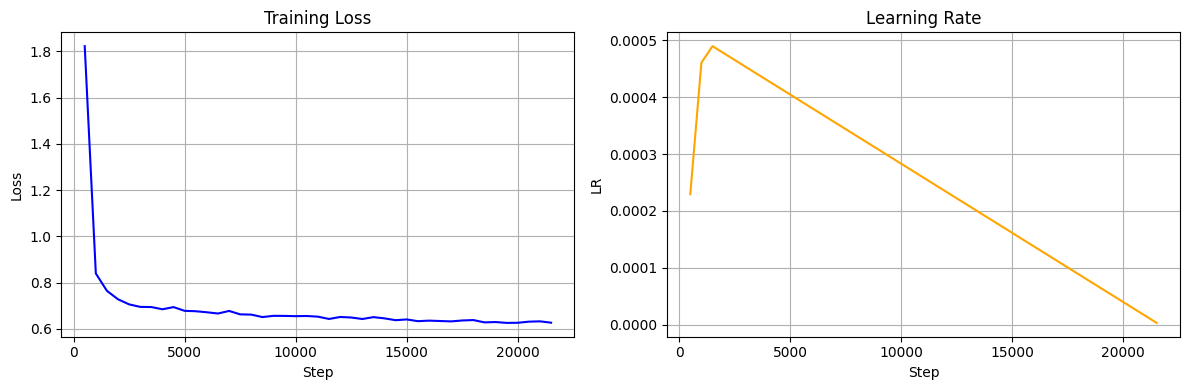

In [12]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import os

log_dir = "/kaggle/working/log"

# 최신 이벤트 파일 찾기
event_file = None
for root, _, files in os.walk(log_dir):
    for file in files:
        if file.startswith("events.out.tfevents"):
            event_file = os.path.join(root, file)

if event_file:
    ea = event_accumulator.EventAccumulator(event_file)
    ea.Reload()

    # ✅ 수정된 태그 사용
    loss_vals = ea.Scalars("train/loss")
    lr_vals = ea.Scalars("train/learning_rate")

    steps_loss = [x.step for x in loss_vals]
    values_loss = [x.value for x in loss_vals]

    steps_lr = [x.step for x in lr_vals]
    values_lr = [x.value for x in lr_vals]

    plt.figure(figsize=(12, 4))

    # 🔹 Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(steps_loss, values_loss, label="loss", color="blue")
    plt.title("Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.grid(True)

    # 🔹 LR plot
    plt.subplot(1, 2, 2)
    plt.plot(steps_lr, values_lr, label="lr", color="orange")
    plt.title("Learning Rate")
    plt.xlabel("Step")
    plt.ylabel("LR")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

else:
    print("❗ TensorBoard 로그 파일을 찾을 수 없습니다.")

In [13]:
# 저장된 토크나이즈 test 데이터 불러오기
import shutil
shutil.copytree("/kaggle/input/test-tokenized", "/kaggle/working/test_tokenized")
from datasets import load_from_disk
test_datasets = load_from_disk("/kaggle/working/test_tokenized/tokenized_val_datasets");test_datasets

Dataset({
    features: ['original_text', 'summary_text', 'source_type', 'input_text', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 36000
})

In [29]:
import torch
from tqdm import tqdm
generated_summaries = []

# test_datasets은 Huggingface Dataset 포맷이라 .select() 가능
for example in tqdm(test_datasets.select(range(100))):  # 예: 10개만 우선 추론
    input_ids = torch.tensor(example["input_ids"]).unsqueeze(0).to(trainer.model.device)
    attention_mask = torch.tensor(example["attention_mask"]).unsqueeze(0).to(trainer.model.device)

    with torch.no_grad():
        output = trainer.model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=192,
            min_length=30,
            num_beams=4,
            repetition_penalty=1.3,
            no_repeat_ngram_size=4,
            early_stopping=True,
        )

    summary = tokenizer.decode(output[0], skip_special_tokens=True)
    generated_summaries.append(summary)

# 결과 보기
for i in range(10):
    print(f"\n[원문] {test_datasets['input_text'][i][:200]}...")
    print(f"[정답 요약] {test_datasets['summary_text'][i]}")
    print(f"[모델 요약] {generated_summaries[i]}")

100%|██████████| 100/100 [02:23<00:00,  1.43s/it]



[원문] [전체요약] 대학에서 시간강사는 교육과 연구를 통해 유능한 인재 배출, 연구 경쟁력 강화, 그리고 국가와 사회의 지식 및 학문 발전에 기여하고 있다. 그러므로 시간강사를 위한 국가 및 대학의 학술연구정보서비스는 그들의 교육․연구 활동에 필수적이다. 이에 본 연구는 시간강사를 대상으로 설문조사 방식을 적용하여 그들이 처한 정보환경과 정보요구 그리고 교육학술정...
[정답 요약] 대학에서 시간강사는 교육과 연구를 통해 유능한 인재 배출, 연구 경쟁력 강화, 그리고 국가와 사회의 지식 및 학문 발전에 기여하고 있다.
시간강사를 위한 국가 및 대학의 학술연구정보서비스는 그들의 교육․연구 활동에 필수적이다.
[모델 요약] 이 연구는 시간강사를 대상으로 설문조사 방식을 적용하여 그들이 처한 정보환경과 정보요구 그리고 교육학술정보에 대한 인식도와 이용행태 등을 조사.분석하여 효율적인 교육학술정보를 제공하기 위한 방안을 제시했다. 
 



[원문] [전체요약] 이 연구는 사회주의기업책임관리제가 지난 20년간 지속된 노동자의 무보수노동에 대해 어떤 해결책을 제시했는지를 묻고, 2010~2019년 사이에 공장사회를 경험한 노동행위자의 시각에서 사회주의기업책임관리제도의 실체를 규명하였다. 이를 위해 박형중의 ‘조직생활사회’라는 개념에기반하여 제도적 문화기술지(Institutional Ethnography)...
[정답 요약] 20년간 노동자의 무보수노동과 노동행위자의 시각에서 사회주의기업책임관리제 관리자의 실체를 규명한 결과 그들의 등장이 지방산업 국영기업을 지배하는 ‘돈주-권력 행위자 네크워크’의 존재와 힘을 추인하는 조치였음을 시사한다.
[모델 요약] 이 연구는 사회주의기업책임관리제가 지난 20년간 지속된 노동자의 무보수노동에 대해 어떤 해결책을 제시했는지를 묻고, 2010~2019년 사이에 공장사회를 경험한 노동행위자의 시각에서 사회주의기업 책임관리제도의 실체를 규명하였다. 연구결과, 실험기의 공장사회는 강한 당적지배, 지배인의 잦은 교체, ‘돈-권력의 행위자 

In [23]:
#!pip install evaluate
#!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=16d64b0e82d1d59b992dc5e43d0d45d207787eccf57d50989f452500ea1370f4
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [30]:
import evaluate

rouge = evaluate.load("rouge")

results = rouge.compute(
    predictions=generated_summaries,
    references=test_datasets["summary_text"][:len(generated_summaries)],
    use_stemmer=True
)

# 결과 출력
for metric, score in results.items():
    print(f"{metric}: {score:.4f}")

rouge1: 0.1585
rouge2: 0.0332
rougeL: 0.1559
rougeLsum: 0.1552


In [27]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing ins

In [31]:
from evaluate import load
bertscore = load("bertscore")

results = bertscore.compute(
    predictions=generated_summaries,
    references=test_datasets["summary_text"][:len(generated_summaries)],
    lang="ko"
)
print(f"mean BERTScore (F1): {sum(results['f1'])/len(results['f1']):.4f}")

mean BERTScore (F1): 0.7871


In [ ]:
# 0.75~0.80	기본 요지는 잡았으나 일부 정보 누락


In [32]:
# 새로 Trainer 선언 (optimizer도 새로 초기화됨)


training_args = Seq2SeqTrainingArguments(
    output_dir="./kobart-peft-summary-v3",     # 출력 디렉토리
    
    per_device_train_batch_size=16,          # 4까지 무리 없음 (토큰 길이에 따라 6~8도 가능)
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,  # 배치 크기 늘리는 효과
           
    learning_rate=5e-4,                     # PEFT에선 조금 크게 잡는 게 안정적
    num_train_epochs=2,                     # 필요시 늘리되, 3부터 시작
    lr_scheduler_type="linear",             # 
    warmup_ratio=0.05,                       # 
    weight_decay=0.01,                      # 규제
    
    #save_steps=1000,
    #save_total_limit=1,
    #predict_with_generate=True,
    fp16=True,                              # 
    eval_strategy="no",              # 검증셋 있을 경우 "steps" 또는 "epoch"    
    save_steps=1000,
    save_total_limit=1,

    logging_dir='/kaggle/working/log',
    logging_steps=500,
    report_to="tensorboard",         
    
    predict_with_generate=True,
)

In [33]:
# 이어서 학습할 모델 그대로
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  
    tokenizer=tokenizer,
    callbacks = [
        StopOnLowLRCallback(lr_threshold=1e-6),
        LoggingCallback(),
    ]
)

/tmp/ipykernel_31/2536167107.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [34]:
trainer.train()

Step,Training Loss
500,0.632900
1000,0.652100
1500,0.651600
2000,0.644000
2500,0.643100
3000,0.642700
3500,0.650000
4000,0.646100
4500,0.649000
5000,0.642800


[Step 500] loss: 0.6329 | lr: 0.000346
[Step 1000] loss: 0.6521 | lr: 0.000490


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 1500] loss: 0.6516 | lr: 0.000472
[Step 2000] loss: 0.6440 | lr: 0.000453


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 2500] loss: 0.6431 | lr: 0.000435
[Step 3000] loss: 0.6427 | lr: 0.000417


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 3500] loss: 0.6500 | lr: 0.000399
[Step 4000] loss: 0.6461 | lr: 0.000380


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 4500] loss: 0.6490 | lr: 0.000362
[Step 5000] loss: 0.6428 | lr: 0.000344


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 5500] loss: 0.6427 | lr: 0.000326
[Step 6000] loss: 0.6414 | lr: 0.000307


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 6500] loss: 0.6361 | lr: 0.000289
[Step 7000] loss: 0.6482 | lr: 0.000271


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 7500] loss: 0.6349 | lr: 0.000252
[Step 8000] loss: 0.6345 | lr: 0.000234


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 8500] loss: 0.6248 | lr: 0.000216
[Step 9000] loss: 0.6312 | lr: 0.000198


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 9500] loss: 0.6310 | lr: 0.000179
[Step 10000] loss: 0.6310 | lr: 0.000161


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 10500] loss: 0.6312 | lr: 0.000143
[Step 11000] loss: 0.6283 | lr: 0.000125


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 11500] loss: 0.6182 | lr: 0.000106
[Step 12000] loss: 0.6275 | lr: 0.000088


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 12500] loss: 0.6256 | lr: 0.000070
[Step 13000] loss: 0.6197 | lr: 0.000052


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 13500] loss: 0.6282 | lr: 0.000033
[Step 14000] loss: 0.6236 | lr: 0.000015


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


[Step 14408]


TrainOutput(global_step=14408, training_loss=0.6356537907339347, metrics={'train_runtime': 14714.16, 'train_samples_per_second': 31.336, 'train_steps_per_second': 0.979, 'total_flos': 1.4118144959840256e+17, 'train_loss': 0.6356537907339347, 'epoch': 1.9997917967936707})

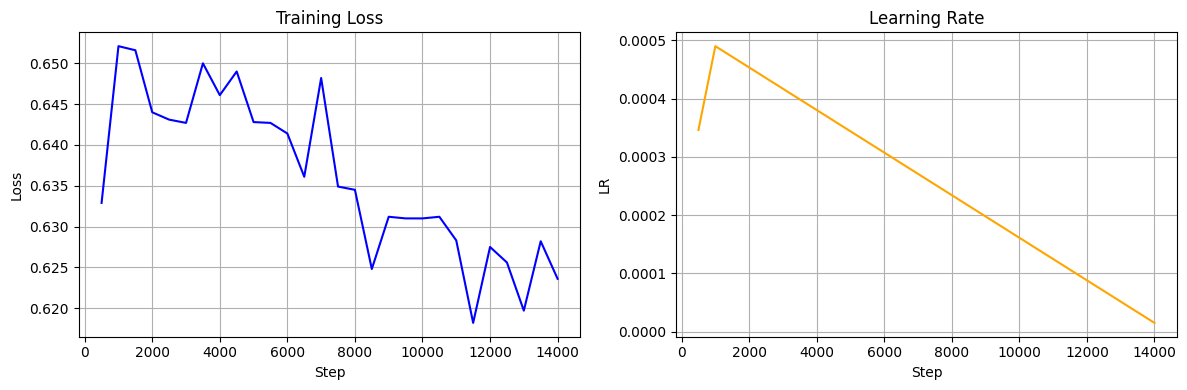

In [35]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import os

log_dir = "/kaggle/working/log"

# 최신 이벤트 파일 찾기
event_file = None
for root, _, files in os.walk(log_dir):
    for file in files:
        if file.startswith("events.out.tfevents"):
            event_file = os.path.join(root, file)

if event_file:
    ea = event_accumulator.EventAccumulator(event_file)
    ea.Reload()

    # ✅ 수정된 태그 사용
    loss_vals = ea.Scalars("train/loss")
    lr_vals = ea.Scalars("train/learning_rate")

    steps_loss = [x.step for x in loss_vals]
    values_loss = [x.value for x in loss_vals]

    steps_lr = [x.step for x in lr_vals]
    values_lr = [x.value for x in lr_vals]

    plt.figure(figsize=(12, 4))

    # 🔹 Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(steps_loss, values_loss, label="loss", color="blue")
    plt.title("Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.grid(True)

    # 🔹 LR plot
    plt.subplot(1, 2, 2)
    plt.plot(steps_lr, values_lr, label="lr", color="orange")
    plt.title("Learning Rate")
    plt.xlabel("Step")
    plt.ylabel("LR")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

else:
    print("❗ TensorBoard 로그 파일을 찾을 수 없습니다.")

In [36]:
trainer.save_model("/kaggle/working/kobart-peft-summary-v3")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


In [38]:
import torch
from tqdm import tqdm
generated_summaries = []

# test_datasets은 Huggingface Dataset 포맷이라 .select() 가능
for example in tqdm(test_datasets.select(range(100))):  # 예: 10개만 우선 추론
    input_ids = torch.tensor(example["input_ids"]).unsqueeze(0).to(trainer.model.device)
    attention_mask = torch.tensor(example["attention_mask"]).unsqueeze(0).to(trainer.model.device)

    with torch.no_grad():
        output = trainer.model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=192,
            min_length=30,
            num_beams=4,
            repetition_penalty=1.3,
            no_repeat_ngram_size=4,
            early_stopping=True,
        )

    summary = tokenizer.decode(output[0], skip_special_tokens=True)
    generated_summaries.append(summary)

# 결과 보기
for i in range(10):
    print(f"\n[원문] {test_datasets['input_text'][i][:200]}...")
    print(f"[정답 요약] {test_datasets['summary_text'][i]}")
    print(f"[모델 요약] {generated_summaries[i]}")

100%|██████████| 100/100 [02:23<00:00,  1.43s/it]



[원문] [전체요약] 대학에서 시간강사는 교육과 연구를 통해 유능한 인재 배출, 연구 경쟁력 강화, 그리고 국가와 사회의 지식 및 학문 발전에 기여하고 있다. 그러므로 시간강사를 위한 국가 및 대학의 학술연구정보서비스는 그들의 교육․연구 활동에 필수적이다. 이에 본 연구는 시간강사를 대상으로 설문조사 방식을 적용하여 그들이 처한 정보환경과 정보요구 그리고 교육학술정...
[정답 요약] 대학에서 시간강사는 교육과 연구를 통해 유능한 인재 배출, 연구 경쟁력 강화, 그리고 국가와 사회의 지식 및 학문 발전에 기여하고 있다.
시간강사를 위한 국가 및 대학의 학술연구정보서비스는 그들의 교육․연구 활동에 필수적이다.
[모델 요약] 본 연구는 시간강사를 대상으로 설문조사 방식을 적용하여 그들이 처한 정보환경과 정보요구 그리고 교육학술정보에 대한 인식도와 이용행태 등을 조사.분석하였다. 





[원문] [전체요약] 이 연구는 사회주의기업책임관리제가 지난 20년간 지속된 노동자의 무보수노동에 대해 어떤 해결책을 제시했는지를 묻고, 2010~2019년 사이에 공장사회를 경험한 노동행위자의 시각에서 사회주의기업책임관리제도의 실체를 규명하였다. 이를 위해 박형중의 ‘조직생활사회’라는 개념에기반하여 제도적 문화기술지(Institutional Ethnography)...
[정답 요약] 20년간 노동자의 무보수노동과 노동행위자의 시각에서 사회주의기업책임관리제 관리자의 실체를 규명한 결과 그들의 등장이 지방산업 국영기업을 지배하는 ‘돈주-권력 행위자 네크워크’의 존재와 힘을 추인하는 조치였음을 시사한다.
[모델 요약] 본 연구는 사회주의기업책임관리제가 지난 20년간 지속된 노동자의 무보수노동에 관해 어떤 해결책을 제시했는지를 묻고, 2010~2019년 사이에 공장사회를 경험한 노동행위자의 시각에서 사회주의기업책임 관리제도의 실체를 규명했다. 기업에 ‘로력조절권’을 부여한이유는 주변으로 밀려난 공장노동자들의 노동시장 이행을 통제하기 위한것으로 보인다.    
 



[원문] [섹션

In [39]:
N = len(generated_summaries)  # 또는 10, 50 등 원하는 개수로 설정
preds = generated_summaries[:N]
refs = test_datasets["summary_text"][:N]

# ---------------------
# 2. ROUGE 평가
# ---------------------
rouge = load("rouge")
rouge_result = rouge.compute(
    predictions=preds,
    references=refs,
    use_stemmer=True
)

# ---------------------
# 3. BERTScore 평가
# ---------------------
bertscore = load("bertscore")
bertscore_result = bertscore.compute(
    predictions=preds,
    references=refs,
    lang="ko"
)
mean_bertscore_f1 = sum(bertscore_result["f1"]) / len(bertscore_result["f1"])

# ---------------------
# 4. 결과 출력
# ---------------------
print("📊 [ROUGE Score]")
for k, v in rouge_result.items():
    print(f"{k}: {v:.4f}")

print("\n📊 [BERTScore]")
print(f"BERTScore F1 평균: {mean_bertscore_f1:.4f}")

📊 [ROUGE Score]
rouge1: 0.1729
rouge2: 0.0407
rougeL: 0.1697
rougeLsum: 0.1696

📊 [BERTScore]
BERTScore F1 평균: 0.7853


In [40]:
# rouge1: 0.1585
# rouge2: 0.0332
# rougeL: 0.1559
# rougeLsum: 0.1552
# mean BERTScore (F1): 0.7871
# 기존 대비 rouge score는 올랐지만 BERTScore는 떨어졌다.

SyntaxError: invalid syntax (2971715219.py, line 5)

In [48]:
os.listdir('/kaggle/working/')

['kobart-peft-summary-v3', 'log']